In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
#|default_exp table_scene_model

In [12]:
#|export
import bayes3d as b3d
import bayes3d.genjax
import joblib
from tqdm import tqdm
import os
import jax.numpy as jnp
import jax
from jax import jit, vmap
import numpy as np
import genjax
import trimesh
import matplotlib.pyplot as plt
from bayes3d.genjax.genjax_distributions import *

# console = genjax.pretty(show_locals=False)

In [13]:
#|export
from jax.scipy.spatial.transform import Rotation
from scipy.stats import truncnorm as scipy_truncnormal

normal_logpdf    = jax.scipy.stats.norm.logpdf
normal_pdf       = jax.scipy.stats.norm.pdf
truncnorm_logpdf = jax.scipy.stats.truncnorm.logpdf
truncnorm_pdf    = jax.scipy.stats.truncnorm.pdf

inv       = jnp.linalg.inv
logaddexp = jnp.logaddexp
logsumexp = jax.scipy.special.logsumexp

key = jax.random.PRNGKey(0)

In [14]:
#|export
from bayes3d._mkl.utils import keysplit
from bayes3d._mkl.plotting import *

## Renderer and meshes

In [15]:
_scaling  = 1e-3
model_dir = os.path.join(b3d.utils.get_assets_dir(),"bop/ycbv/models")

meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    mesh = trimesh.load(mesh_path)
    mesh.vertices *= _scaling 
    meshes.append(mesh)


# Add invisible atomic table
mesh_path = os.path.join(b3d.utils.get_assets_dir(), "sample_objs/cube.obj")
mesh = trimesh.load(mesh_path)
mesh.vertices *= 1e-9
meshes.append(mesh)


In [17]:
# Set up the renderer and add the scene mesh
def make_render_function(meshes, w=100, h=100, fx=30, fy=30, offx=-0.5, offy=-0.5, far=20, near=0.01):
    """
    Create a render function from a list of meshes 
    (and camera intrinsics).
    """
    intrinsics = b3d.Intrinsics(
        width = w, height = h,
        fx = fx, fy = fy,
        cx = w/2 + offx, cy = h/2 + offy,
        near = near, far = far
    )
    
    b3d.setup_renderer(intrinsics)
    for mesh in meshes: b3d.RENDERER.add_mesh(mesh, center_mesh=True)

    def render(cam:"Camera Pose", ps:"Object Poses", inds:"Object indices"):
        """
        Returns image of shape `(h, w, 4)` where the first 3 channels encode 
        xyz-coordinates and the last channel encodes semantic information.
        """
        return b3d.RENDERER.render(inv(cam) @ ps , inds)

    return render

In [18]:
_far   = 5.0
_shape = (200,200)
_f     = 300

_intr   = dict(w=_shape[1], h=_shape[0], fx=_f, fy=_f, near=1e-4, far=_far)
render   = make_render_function(meshes, **_intr)

help(render)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (224, 224, 1024)
Help on function render in module __main__:

render(cam: 'Camera Pose', ps: 'Object Poses', inds: 'Object indices')
    Returns image of shape `(h, w, 4)` where the first 3 channels encode 
    xyz-coordinates and the last channel encodes semantic information.



In [20]:
def prep_im(Y, far=5.0, eps=1e-6):
    im = np.where(Y[:,:,2]>= far - eps, jnp.inf, Y[:,:,2])
    return im

## Scene model

In [21]:
#|export
def make_table_scene_model():
    """
    Example:

    ```
    key = keysplit(key)

    model = make_table_scene_model()

    table = jnp.eye(4)
    cam   = b3d.transform_from_pos_target_up(
                jnp.array([0.0, -.5, -.75]), 
                jnp.zeros(3), 
                jnp.array([0.0,-1.0,0.0]))

    args = (
        jnp.arange(3), 
        jnp.arange(22), 
        jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
        jnp.array([jnp.array([-0.2, -0.2, -2*jnp.pi]), jnp.array([0.2, 0.2, 2*jnp.pi])]),
        b3d.RENDERER.model_box_dims
    )

    ch = genjax.choice_map({
        "parent_0": -1,
        "parent_1":  0,
        "parent_2":  0,
        "camera_pose": cam,
        "root_pose_0": table,
        "id_0": jnp.int32(21), # Atomic Table
        "id_1": jnp.int32(13), # Mug
        "id_2": jnp.int32(2),  # Box
        "face_parent_1": 1,  # That's the top face of the table
        "face_parent_2": 1,  # ...
        "face_child_1": 3,   # That's a bottom face of the mug
        "face_child_2": 3,
    })

    w, tr = model.importance(key, ch , args)
    cam, ps, inds = tr.retval
    X = render(cam, ps, inds)

    # =====================
    plt.imshow(X[...,2])
    ```
    """

    @genjax.gen
    def model(nums, 
              possible_object_indices, 
              pose_bounds, 
              contact_bounds, 
              all_box_dims):
        
        num_objects = len(nums) # this is a hack, otherwise genajx is complaining

        indices        = jnp.array([], dtype=jnp.int32)
        root_poses     = jnp.zeros((0,4,4))
        contact_params = jnp.zeros((0,3))
        faces_parents  = jnp.array([], dtype=jnp.int32)
        faces_child    = jnp.array([], dtype=jnp.int32)
        parents        = jnp.array([], dtype=jnp.int32)

        for i in range(num_objects):

            index  = uniform_discrete(possible_object_indices)    @ f"id_{i}"
            pose   = uniform_pose(pose_bounds[0], pose_bounds[1]) @ f"root_pose_{i}"
            params = contact_params_uniform(contact_bounds[0], contact_bounds[1]) @ f"contact_params_{i}"

            parent_obj  = uniform_discrete(jnp.arange(-1, num_objects - 1)) @ f"parent_{i}"
            parent_face = uniform_discrete(jnp.arange(0,6)) @ f"face_parent_{i}"
            child_face  = uniform_discrete(jnp.arange(0,6)) @ f"face_child_{i}"

            indices        = jnp.concatenate([indices, jnp.array([index])])
            root_poses     = jnp.concatenate([root_poses, pose.reshape(1,4,4)])
            contact_params = jnp.concatenate([contact_params, params.reshape(1,-1)])
            parents        = jnp.concatenate([parents, jnp.array([parent_obj])])
            faces_parents  = jnp.concatenate([faces_parents, jnp.array([parent_face])])
            faces_child    = jnp.concatenate([faces_child, jnp.array([child_face])])
        

        scene = (root_poses, all_box_dims[indices], parents, contact_params, faces_parents, faces_child)
        poses = b.scene_graph.poses_from_scene_graph(*scene)

        camera_pose = uniform_pose(pose_bounds[0], pose_bounds[1]) @ f"camera_pose"

        return camera_pose, poses, indices

    return model

## Example

In [22]:
model = make_table_scene_model()

(200, 200, 4)


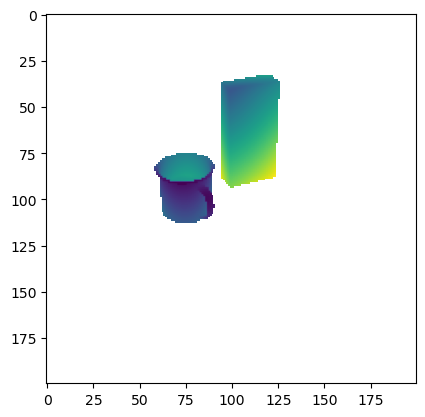

In [30]:
key = keysplit(key)

cam_x = jnp.array([0.0, -.5, -.75])
cam   = b3d.transform_from_pos_target_up(cam_x, jnp.zeros(3), jnp.array([0.0,-1.0,0.0]))

table = jnp.eye(4)

args = (
    jnp.arange(3),
    jnp.arange(22),
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
    jnp.array([jnp.array([-0.2, -0.2, -2*jnp.pi]), jnp.array([0.2, 0.2, 2*jnp.pi])]),
    b3d.RENDERER.model_box_dims
)

ch = genjax.choice_map({
    "parent_0": -1,
    "parent_1":  0,
    "parent_2":  0,
    "camera_pose": cam,
    "root_pose_0": table,
    "id_0": jnp.int32(21), # Atomic Table
    "id_1": jnp.int32(13), # Mug
    "id_2": jnp.int32(2),  # Box
    "face_parent_1": 1,  # That's the top face of the table
    "face_parent_2": 1,  # ...
    "face_child_1": 3,   # That's a bottom face of the mug
    "face_child_2": 3,
})


w, tr = model.importance(key, ch , args)
cam, ps, inds = tr.retval
X = render(cam, ps, inds)

print(X.shape)
# =====================
plt.imshow(prep_im(X))

In [31]:
fname = f"table_scene_3"
jnp.save(f"data/likelihood_test/{fname}", dict(
    key        = key,
    args       = tr.args,
    choices    = tr.strip(), 
    intrinsics = _intr,
    rendered   = X,
))

In [20]:
fname = f"table_scene_3"
arr = jnp.load(f"data/likelihood_test/{fname}.npy", allow_pickle=True)
ch = arr.item()["choices"]


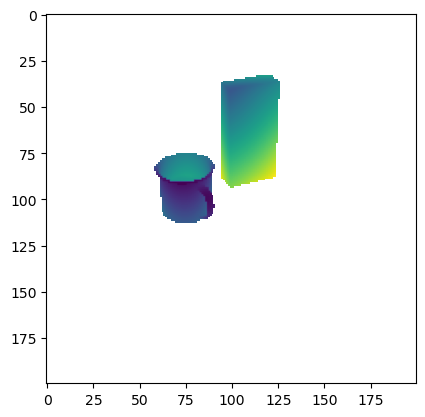

In [183]:
_, tr_ = model.importance(key, ch , args)
cam, ps, inds = tr_.retval
X = render(cam, ps, inds)

# =====================
plt.imshow(prep_im(X))

## Generic Viewpoint

In [50]:
from bayes3d._mkl.pose import pack_pose

def generic_viewpoint(key, cam, n, sig_x, sig_hd):
    """Generates generix camera poses by varying its xy-coordinates and angle (in the xy-plane)."""
    
    # TODO: Make a version that varies rot and pitch and potentially roll.
    
    _, keys = keysplit(key,1,2)

    # Generic position
    xs = sig_x*jax.random.normal(keys[1], (n,3))
    xs = xs.at[0,:].set(0.0)
    xs = xs.at[:,2].set(0.0)

    # Generic rotation
    hds = sig_hd*jax.random.normal(keys[0], (n,))
    hds = hds.at[0].set(0.0)
    rs = vmap(Rotation.from_euler, (None,0))("y", hds)
    rs = Rotation.as_matrix(rs)
    
    # Generic camera poses
    ps = vmap(pack_pose)(xs, rs)
    ps = cam@ps

    # Generic weights
    logps_hd = normal_logpdf(hds, loc=0.0, scale=sig_hd)
    logps_x  = normal_logpdf( xs, loc=0.0, scale=sig_x).sum(-1)
    logps    = logps_hd + logps_x

    return ps, logps


In [51]:
def generic_contact(key, p0, n, sig_x, sig_hd):

    _, keys = keysplit(key,1,2)

    # Generic contact-pose vector
    xs  = sig_x*jax.random.normal(keys[1], (n,3))
    xs  = xs.at[:,2].set(0.0)
    xs  = xs.at[0,:].set(0.0)

    hds = sig_hd*jax.random.normal(keys[0], (n,1))
    hds = hds.at[0,:].set(0.0)
    rs = vmap(Rotation.from_euler, (None,0))("z", hds)
    rs = Rotation.as_matrix(rs)
    
    # Generic camera poses
    ps = vmap(pack_pose)(xs, rs)
    # vs  = jnp.concatenate([xs, hds], axis=1)

    # Generic weights
    logps_hd = normal_logpdf(hds[:,0], loc=0.0, scale=sig_hd)
    logps_x  = normal_logpdf (xs, loc=0.0, scale=sig_x).sum(-1)
    logps    = logps_hd + logps_x

    # Generic object pose
    generic_ps = p0@ps

    return generic_ps, logps



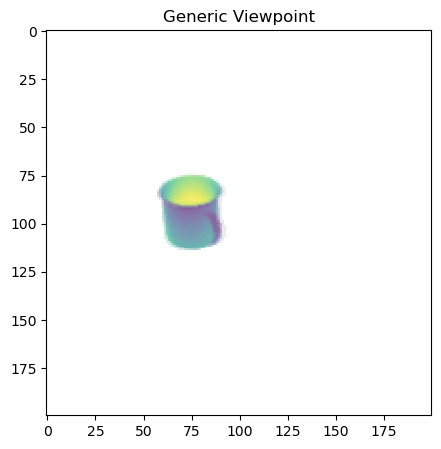

In [235]:
key = keysplit(key)
p0 = ps[1]
generic_ps, ws = generic_contact(key, p0, n=10, sig_x=0.004, sig_hd=0.01)
ws -= logsumexp(ws)


Ys = vmap(render, (None,0,None))(cam, generic_ps[:,None], inds[1][None])


# ==============================
plt.figure(figsize=(5,5))
plt.title("Generic Viewpoint")
for Y in Ys[:]:
    plt.imshow(prep_im(Y), alpha=0.1)

In [236]:
def get_linear_grid(shape, bounds, flat=False):
    """Create a (linear) grid of a given shape and bounds."""
    
    linspaces = [jnp.linspace(*b, d) for b,d in zip(bounds, shape)]
    vs = jnp.stack(jnp.meshgrid(*linspaces, indexing='ij'), axis=-1)
    if flat: vs = vs.reshape(-1,len(shape))
    
    return vs

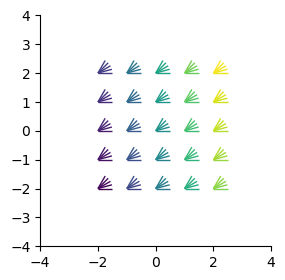

In [237]:
vs = get_linear_grid((5, 5, 5), ((-2,2), (-2,2), (0,jnp.pi/3)), flat=True)
sc = jnp.arange(len(vs))

# =======================================
fig, ax = plt.subplots(1,1,figsize=(3,3))
zoom_in(vs[:,:2], 2, ax=ax)
plot_poses(vs, sc, linewidth=1, ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [238]:
def _contact_from_grid(v, p0=jnp.eye(4), sig_x=1.0, sig_hd=1.0):
    x = jnp.array([*v[:2],0.0])
    hd = v[2]

    r = Rotation.from_euler("z", hd)
    r = Rotation.as_matrix(r)
    p = pack_pose(x, r)

    logp_hd = normal_logpdf(hd, loc=0.0, scale=sig_hd)
    logp_x  = normal_logpdf (x, loc=0.0, scale=sig_x).sum(-1)
    logp    = logp_hd + logp_x

    return p0@p, logp

contact_from_grid = vmap(_contact_from_grid, (0,None,None,None))

In [241]:
dx  = 0.1
dhd = jnp.pi/4
sig_hd = dhd
sig_x  = dx

ley = keysplit(key)
v0 = 0.01*jax.random.normal(key, (3,))
vs = get_linear_grid((10, 10, 10), ((-dx,dx), (-dx,dx), (-dhd,dhd)), flat=True)
vs += v0


generic_ps, logps = contact_from_grid(vs, p0, sig_x, sig_hd)

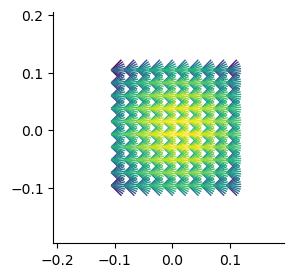

In [244]:
sc =  logps

# =======================================
fig, ax = plt.subplots(1,1,figsize=(3,3))
zoom_in(vs[:,:2], 0.1, ax=ax)
plot_poses(vs, sc, r=0.025, linewidth=1, ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [ ]:
render_generic = jit(vmap(render, (None,0,None)))

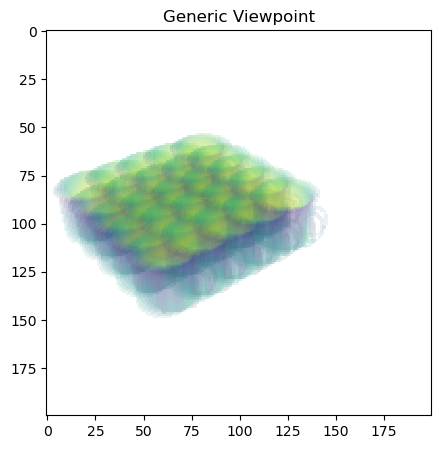

In [178]:
Ys = vmap(render, (None,0,None))(cam, generic_ps[:,None], inds[1][None])

# ==============================
plt.figure(figsize=(5,5))
plt.title("Generic Viewpoint")
for Y in Ys[:]:
    plt.imshow(prep_im(Y), alpha=.1)